In [19]:
%pylab inline
plt.rcParams['figure.figsize'] = [10, 5]
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


In [20]:
# load dataset
labels = ["mntcm", "mxtwm", "rfseas", "tann", "latitude", "longitude", "y"]
dataset = pd.read_csv('dataset_bees.csv', names=labels)
dataset

,mntcm,mxtwm,rfseas,tann,latitude,longitude,y
0,6.0,23.0,36.0,14.0,17.0,50.0,0.0
1,6.0,23.0,36.0,14.0,17.0,51.0,1.0
2,6.0,23.0,35.0,13.0,17.0,52.0,0.0
3,5.0,22.0,35.0,13.0,17.0,53.0,0.0
4,5.0,23.0,35.0,13.0,17.0,54.0,0.0
...,...,...,...,...,...,...,...
9433,7.0,27.0,76.0,17.0,108.0,77.0,0.0
9434,7.0,27.0,76.0,16.0,108.0,78.0,0.0
9435,5.0,28.0,76.0,15.0,108.0,79.0,0.0
9436,8.0,27.0,76.0,17.0,108.0,80.0,0.0


y
0.0    9310
1.0     126
dtype: int64


<AxesSubplot:xlabel='y', ylabel='count'>

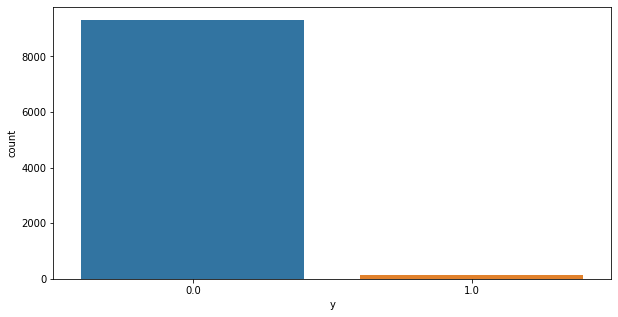

In [21]:
# drop latitude and longitude
dataset = dataset.drop(['latitude', 'longitude'], axis=1)
# drop nan values
dataset = dataset.dropna()

# visualize count info
print(dataset.groupby('y').size())
sns.countplot(x=dataset["y"], label="Count")


In [15]:
# visualize all labels
dataset.describe()

,mntcm,mxtwm,rfseas,tann,y
count,9436.000000,9436.000000,9436.000000,9436.000000,9436.000000
mean,1.580755,28.059983,38.677194,12.766956,0.013353
std,2.791187,3.897386,14.776586,2.866737,0.114788
min,-11.000000,10.000000,11.000000,-1.000000,0.000000
25%,0.000000,25.000000,27.000000,11.000000,0.000000
50%,1.000000,28.000000,37.000000,13.000000,0.000000
75%,4.000000,31.000000,51.000000,15.000000,0.000000
max,8.000000,36.000000,78.000000,18.000000,1.000000


mntcm        AxesSubplot(0.125,0.536818;0.110714x0.343182)
mxtwm     AxesSubplot(0.257857,0.536818;0.110714x0.343182)
rfseas    AxesSubplot(0.390714,0.536818;0.110714x0.343182)
tann      AxesSubplot(0.523571,0.536818;0.110714x0.343182)
dtype: object

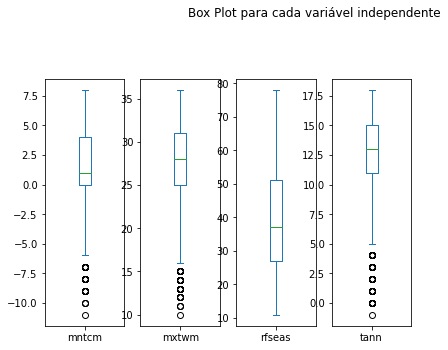

In [16]:
dataset.drop('y', axis=1).plot(kind='box', subplots=True, layout=(2,6),
                                        sharex=False, sharey=False, figsize=(10,10),
                                        title='Box Plot para cada variável independente')

## Balance Data

Imbalanced
0: 9310
1: 126


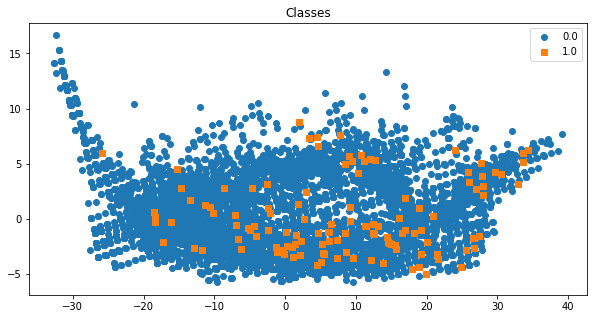

Under-Sample
0: 126
1: 126


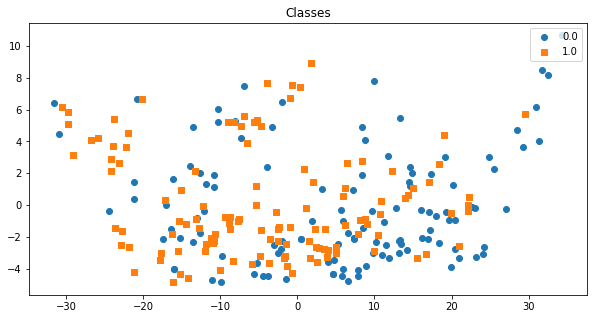

Over-Sample
0: 9310
1: 9310


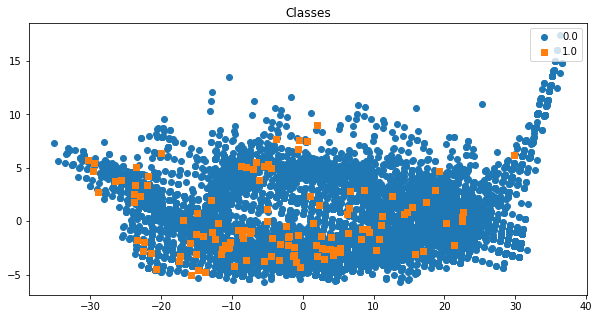

SMOTE
0: 9310
1: 9310


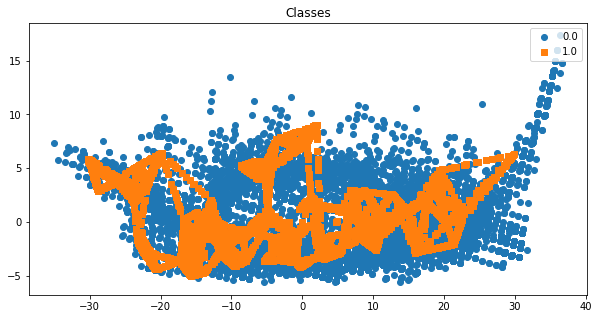

In [28]:
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE


X = dataset.drop('y', axis=1).values
y = dataset['y'].values

DATA = {
  'Imbalanced':{'X':None, 'y':None},
  'Under-Sample':{'X':None, 'y':None},
  'Over-Sample':{'X':None, 'y':None},
  'SMOTE':{'X':None, 'y':None}
}

def balance_data(X, y, algo=None):
  
  if algo is not None:
    X_balanced, y_balanced = algo.fit_resample(X, y)
  else:
    X_balanced, y_balanced = X, y

  #sns.countplot(x=y_balanced, label="Count")
  print(f'0: {np.count_nonzero(y_balanced == 0)}\n1: {np.count_nonzero(y_balanced == 1)}')
  
  def plot2d(X, y):
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title('Classes')
    plt.legend(loc='upper right')
    plt.show()

  # plot data distribution in 2d
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X_balanced)
  plot2d(X_pca, y_balanced)
  
  return X_balanced, y_balanced

keys_algos = zip(DATA.keys(), [None, RandomUnderSampler(), RandomOverSampler(), SMOTE()])
for k,algo in keys_algos:
  print(k)
  DATA[k]['X'], DATA[k]['y'] = balance_data(X, y, algo=algo)



## Data Normalization

In [29]:
def normalize(X):
  return preprocessing.StandardScaler().fit(X).transform(X)
for k in DATA.keys():
  DATA[k]['X'] = normalize(DATA[k]['X'])

## Classifiers Comparison

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc
from scipy import interp

class Classifiers:
  def __init__(self, X, y, models={}):
    self.X = X
    self.y = y
    self.models = models
    self.skf = StratifiedKFold(n_splits=10)

  def run_all(self):
    for k,model in self.models.items():
      # train model
      print(f'----------- {k} -----------')
      tprs = []
      aucs = []
      mean_fpr = np.linspace(0, 1, 100)
      for i,(train,test) in enumerate(self.skf.split(self.X, self.y)):
        # train
        model.fit(self.X[train],self.y[train])
        # test model
        y_pred = model.predict(self.X[test])
        # ROC curve
        fpr, tpr, t = roc_curve(self.y[test], y_pred)
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)'%(i+1,roc_auc))
    
      plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
      mean_tpr = np.mean(tprs, axis=0)
      mean_auc = auc(mean_fpr, mean_tpr)
      plt.plot(mean_fpr, mean_tpr, color='blue',
              label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC')
      plt.legend(loc="lower right")
      plt.show()

Imbalanced
----------- K Neighbors Classifier -----------


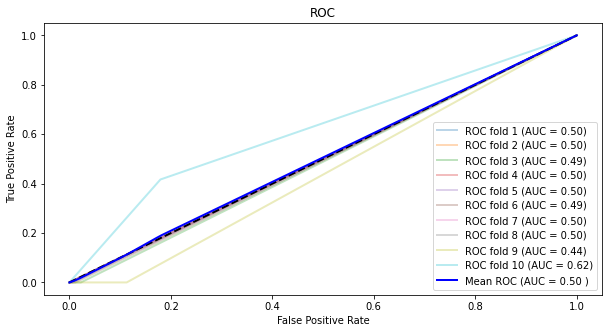

----------- Support Vector Machine -----------


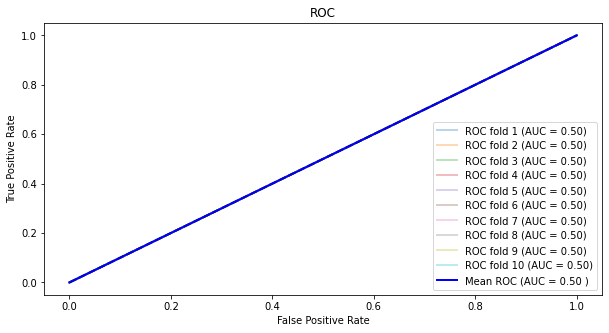

----------- Decision Tree Classifier -----------


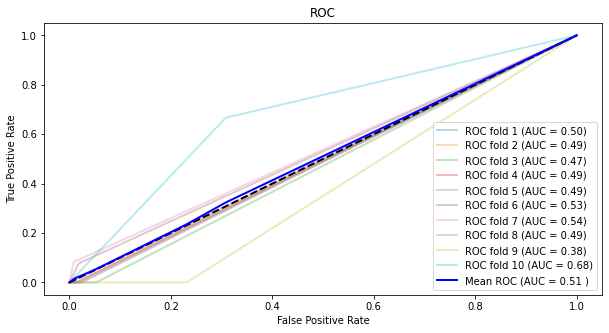

----------- Random Forest Classifier -----------


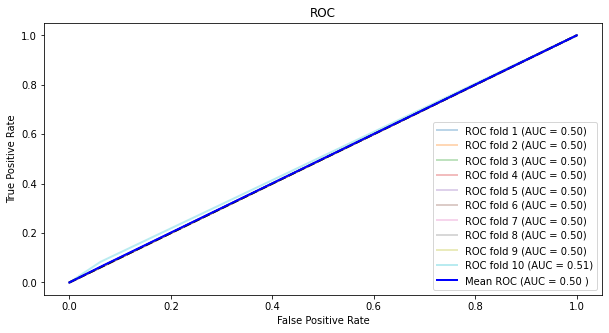

----------- Logistic Regression -----------


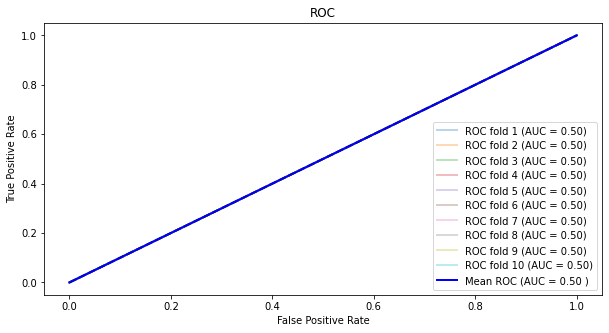

Under-Sample
----------- K Neighbors Classifier -----------


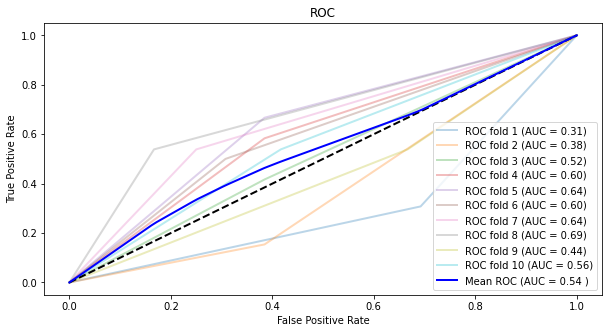

----------- Support Vector Machine -----------


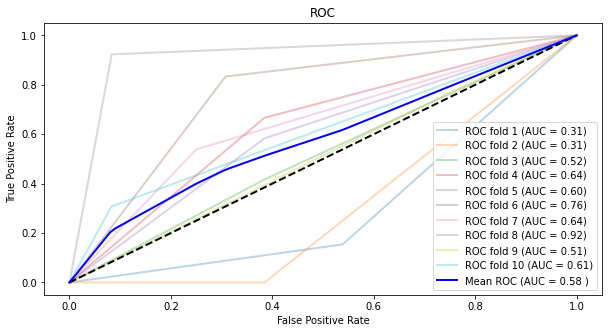

----------- Decision Tree Classifier -----------


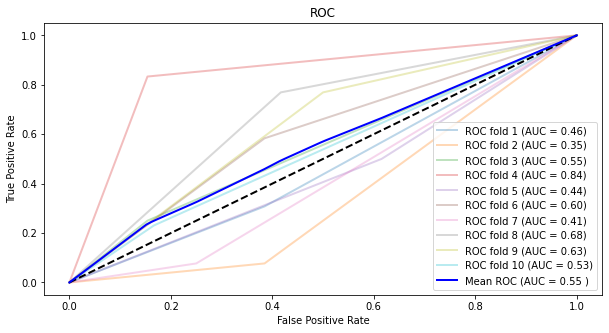

----------- Random Forest Classifier -----------


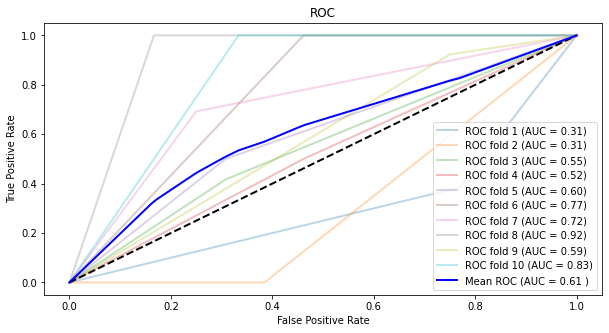

----------- Logistic Regression -----------


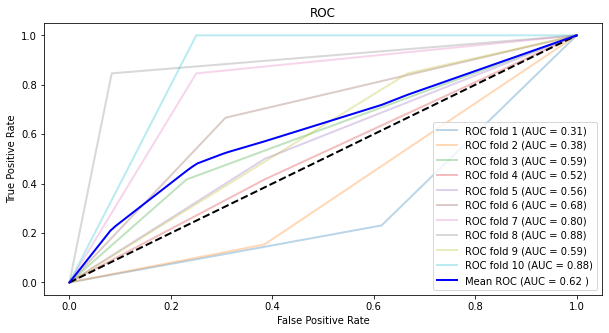

Over-Sample
----------- K Neighbors Classifier -----------


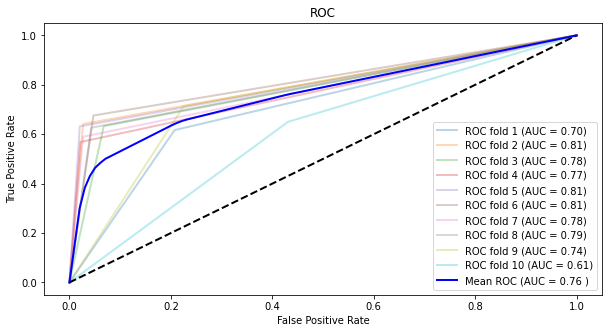

----------- Support Vector Machine -----------


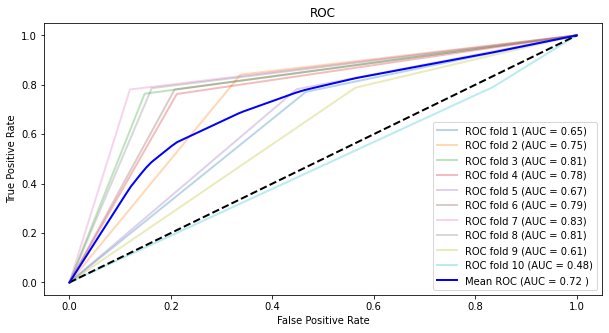

----------- Decision Tree Classifier -----------


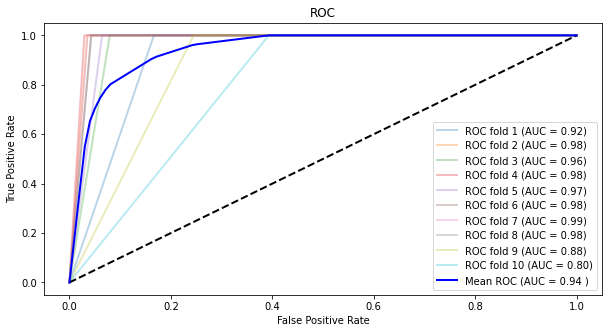

----------- Random Forest Classifier -----------


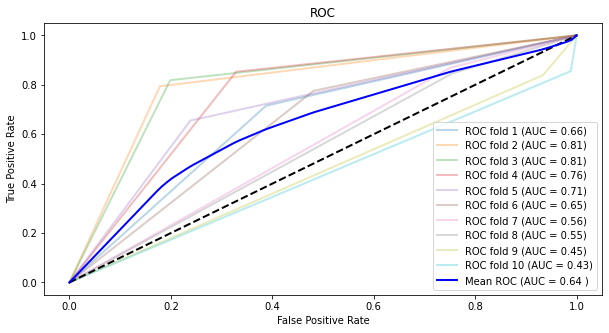

----------- Logistic Regression -----------


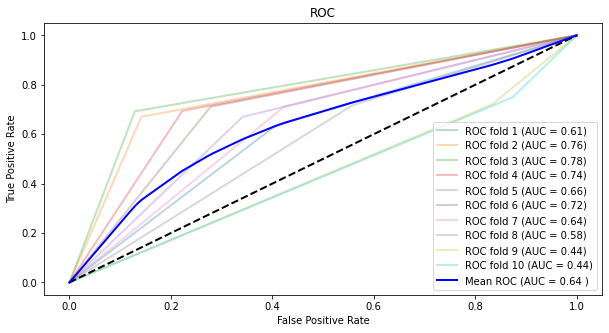

SMOTE
----------- K Neighbors Classifier -----------


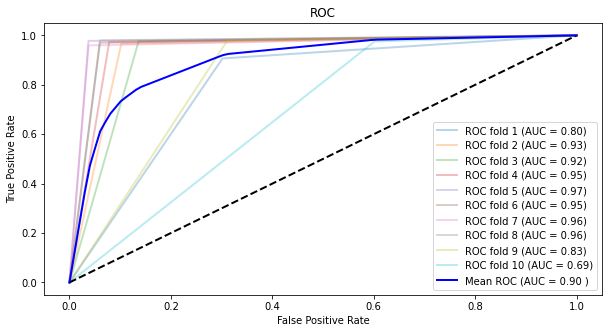

----------- Support Vector Machine -----------


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


for k in DATA.keys():
  print(k)
  classifiers = Classifiers(
    X=DATA[k]['X'], y=DATA[k]['y'],
    models={
      "K Neighbors Classifier":KNeighborsClassifier(n_neighbors=3),
      "Support Vector Machine":SVC(),
      "Decision Tree Classifier":DecisionTreeClassifier(),
      "Random Forest Classifier":RandomForestClassifier(max_depth=2),
      "Logistic Regression":LogisticRegression(),
    }
  )
  classifiers.run_all()

----------- KNN -----------


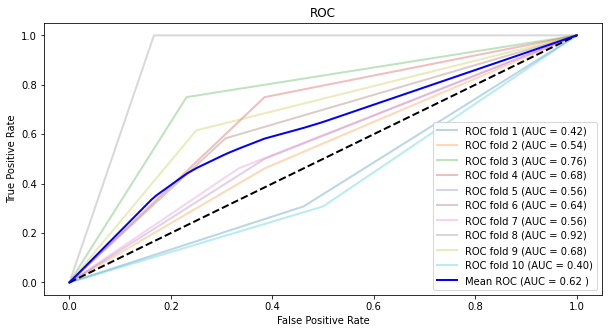

----------- SVC -----------


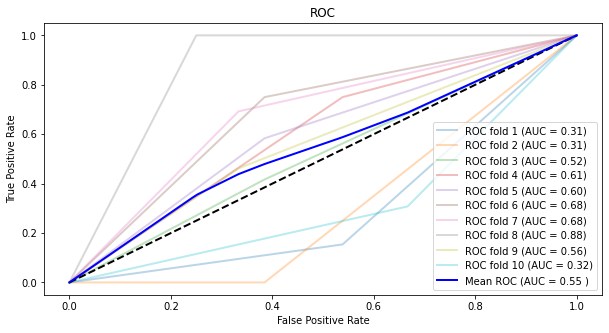

----------- DTC -----------


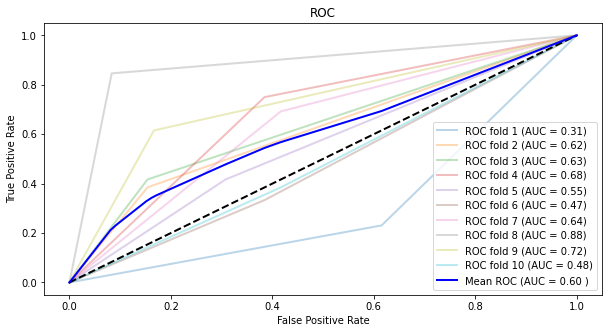

----------- RFC -----------


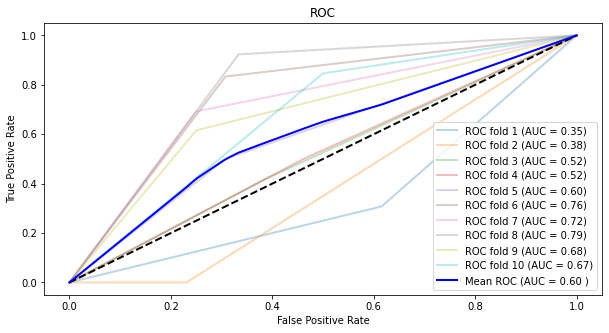

----------- LGR -----------


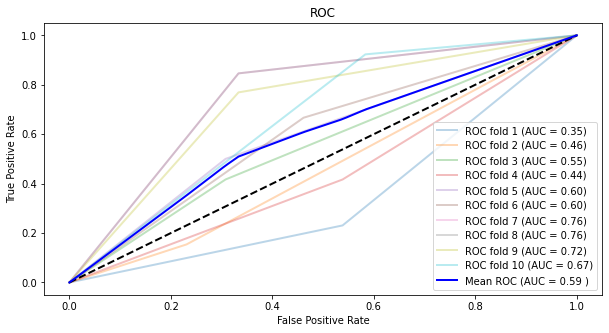

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm import trange

class Model(nn.Module):
  def __init__(self, input_dim):
    super(Model, self).__init__()
    self.sequential = nn.Sequential(
      nn.Linear(input_dim, 50),
      nn.ReLU(),
      nn.Linear(50, 50),
      nn.ReLU(),
      nn.Linear(50, 1),
      nn.Sigmoid()
    )
  
  def forward(self, x):
    return self.sequential(x)

class NNet:
  def __init__(self, model):
    self.model = model
    self.optimizer = torch.optim.Adam(
      self.model.parameters(), lr=0.01
    )
    self.criterion = nn.BCELoss()
    self.epochs = 100
  
  def fit(self, X_train, y_train):
    X_train = torch.tensor(X_train).float()
    y_train = torch.tensor(y_train).float()

    loop = trange(self.epochs)
    for _ in loop:
      y_pred = self.model(X_train)

      # cost function
      loss = self.criterion(y_pred, y_train.unsqueeze(1))

      # zero grad
      self.optimizer.zero_grad()
      # backward
      loss.backward()
      self.optimizer.step()

      loop.set_description(f'Loss: {loss.item()}')
  
  def predict(self, X_test):
    X_test = torch.tensor(X_test).float()
    #y_test = torch.tensor(y_test).float()

    return self.model(X_test) 


#net = NNet(Model(4))
#net.fit(X_train, y_train)